In [2]:
import numpy as np
import PRF
import tessreduce as tr
import matplotlib.pyplot as plt
%matplotlib widget
from skimage.util.shape import view_as_windows
from scipy.optimize import minimize
from tqdm import tqdm

getting TPF from TESScut
made reference
made source mask
calculating background
background subtracted
calculating centroids
!!Re-running for difference image!!
shifting images
remade mask
background
Background correlation correction
Field calibration
Target is below -30 dec, calibrating to SkyMapper photometry.


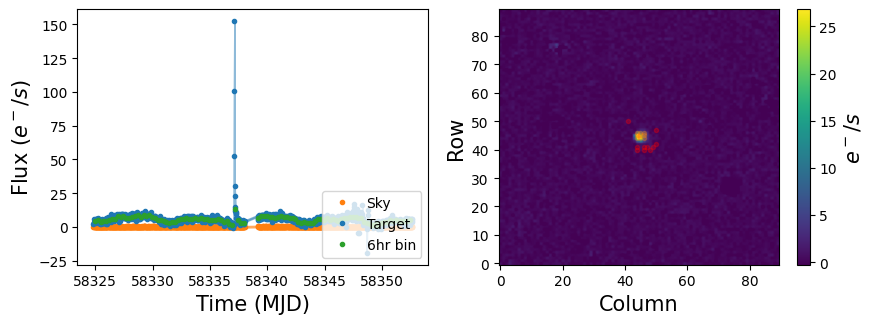

In [5]:
tess = tr.tessreduce(ra=348.786,dec=-45.328,sector=1,plot=False,reduce=True)

In [7]:
def downSample2d(arr,sf):

    isf2 = 1.0/(sf*sf)    # scalefactor
    windows = view_as_windows(arr, (sf,sf), step = sf)  # automatically scale down
    return windows.sum(3).sum(2)*isf2

class create_psf():
    def __init__(self,prf,size,repFact=10):
        
        self.prf = prf
        self.size = size
        self.source_x = 0         # offset of source from centre
        self.source_y = 0         # offset of source from centre
        self.repFact=repFact     # supersample multiplication

        # -- Finds centre of kernel -- #
        self.cent=self.size/2.-0.5

        self.psf = None

    def source(self,shiftx=0,shifty=0):
        
        centx_s = self.cent + shiftx    # source centre
        centy_s = self.cent + shifty

        psf = self.prf.locate(centx_s,centy_s, (self.size,self.size))
        self.psf = psf/np.nansum(psf)

    def minimize_position(self,coeff,image):

        self.source_x = coeff[0]
        self.source_y = coeff[1]
        
        # -- generate psf -- #
        self.source(shiftx = self.source_x, shifty = self.source_y)

        # -- calculate residuals -- #
        diff = abs(image - self.psf)
        residual = np.nansum(diff)
        return np.exp(residual)
    
    def psf_position(self,image,limx=1,limy=1):
        """
        Fit the PSF. Limx,y dictates bounds for position of the source
        """

        normimage = image / np.nansum(image)    # normalise the image
        coeff = [self.source_x,self.source_y]
        lims = [[-limx,limx],[-limy,limy]]
        
        # -- Optimize -- #
        res = minimize(self.minimize_position, coeff, args=normimage, method='Powell',bounds=lims)
        self.psf_fit = res

    def minimize_psf_flux(self,coeff,image):
        res = np.nansum(abs(image - self.psf*coeff[0]))
        return res

    def psf_flux(self,image):
        if self.psf is None:
            self.source(shiftx=self.source_x,shifty=self.source_y)
            
        mask = np.zeros_like(self.psf)
        mask[self.psf > np.nanpercentile(self.psf,70)] = 1
        f0 = np.nansum(image*mask)
        bkg = np.nanmedian(image[~mask.astype(bool)])
        image = image - bkg
        
        #f0 = np.nansum(image)

        res = minimize(self.minimize_psf_flux,f0,args=(image),method='Nelder-Mead')
        self.flux = res.x[0]
        self.image_residual = image - self.psf*self.flux

def _initialise(trObj,cutoutSize,loc):
    """
    For gathering the cutouts and PRF base.
    """

    col = trObj.tpf.column - int(trObj.size/2-1) + loc[0] # find column and row, when specifying location on a *say* 90x90 px cutout
    row = trObj.tpf.row - int(trObj.size/2-1) + loc[1] 
        
    prf = PRF.TESS_PRF(trObj.tpf.camera,trObj.tpf.ccd,trObj.tpf.sector,col,row) # initialise psf kernel
    cutout = trObj.flux[:,loc[1]-cutoutSize//2:loc[1]+1+cutoutSize//2,loc[0]-cutoutSize//2:loc[0]+1+cutoutSize//2] # gather cutouts
    return prf, cutout

def psf_photometry(trObj,xPix,yPix,size=5,repFact=10,snap=None):
    """
    Main Function! Just switch trObj to self inside tessreduce and all should follow.

    --------
    Inputs:
    
    trObj : tessreduce object
    xPix : x pixel location of target region
    yPix : y pixel location of target region
    size : size of cutout to use (should be odd)
    repFact : super sampling factor for modelling
    
    --------
    Options:

    snap : Determines how psf position is fit.
        - None = each frame's position will be fit and used when fitting for flux
        - 'brightest' = the position of the brightest cutout frame will be applied to all subsequent frames
        - int = providing an integer allows for explicit choice of which frame to use as position reference

    --------
    Returns:

    flux : flux light curve across entire sector.

    """

    prf, cutouts = _initialise(trObj,size,(xPix,yPix))   # gather base PRF and the array of cutouts data
    
    flux = []

    if snap == None:  # if no snap, each cutout has their position fitted and considered during flux fitting
        xShifts = []
        yShifts = []
        for cutout in tqdm(cutouts):
            PSF = create_psf(prf,size,repFact)
            PSF.psf_position(cutout)
            PSF.psf_flux(cutout)
            flux.append(PSF.flux)
            yShifts.append(PSF.source_y)
            xShifts.append(PSF.source_x)

        fig,ax = plt.subplots(ncols=3,figsize=(12,4))
        ax[0].plot(flux)
        ax[0].set_ylabel('Flux')
        ax[1].plot(xShifts,marker='.',linestyle=' ')
        ax[1].set_ylabel('xShift')
        ax[2].plot(yShifts,marker='.',linestyle=' ')
        ax[2].set_ylabel('yShift')

    elif snap == 'brightest':      # each cutout has position snapped to brightest frame fit position
        brightest = np.where(cutouts==np.nanmax(cutouts))[0][0]
        base = create_psf(prf,size)
        base.psf_position(cutouts[brightest])
        for cutout in tqdm(cutouts):
            PSF = create_psf(prf,size,repFact)
            PSF.source_x = base.source_x
            PSF.source_y = base.source_y
            PSF.psf_flux(cutout)
            flux.append(PSF.flux)
        fig,ax = plt.subplots(ncols=1,figsize=(12,4))
        ax.plot(flux)
        ax.set_ylabel('Flux')
    
    else:       # each cutout has position snapped to 'snap' frame fit position (snap is integer)
        base = create_psf(prf,size)
        base.psf_position(cutouts[snap])
        for cutout in tqdm(cutouts):
            PSF = create_psf(prf,size,repFact)
            PSF.source_x = base.source_x
            PSF.source_y = base.source_y
            PSF.psf_flux(cutout)
            flux.append(PSF.flux)
        fig,ax = plt.subplots(ncols=1,figsize=(12,4))
        ax.plot(flux)
        ax.set_ylabel('Flux')

    return flux


100%|██████████| 1267/1267 [00:00<00:00, 1812.19it/s]


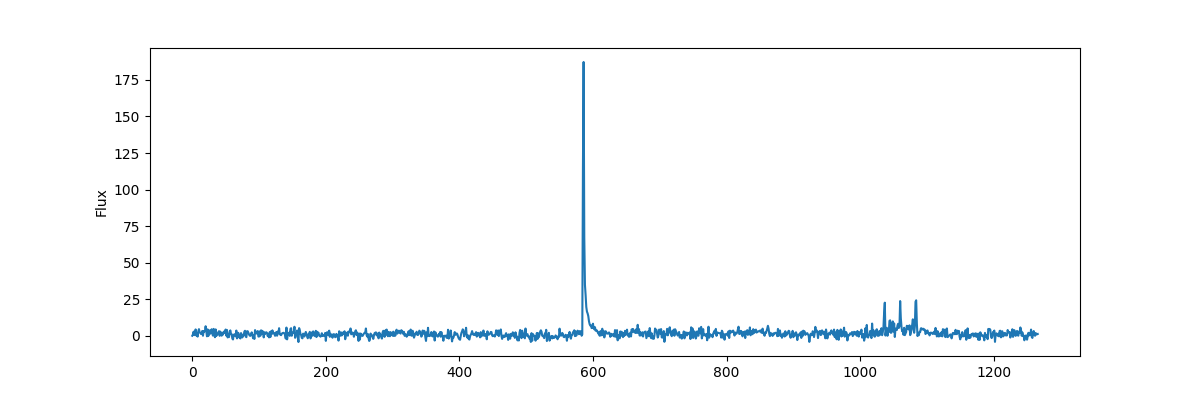

In [249]:
flux = psf_photometry(tess,44,45,snap='brightest',size=5)

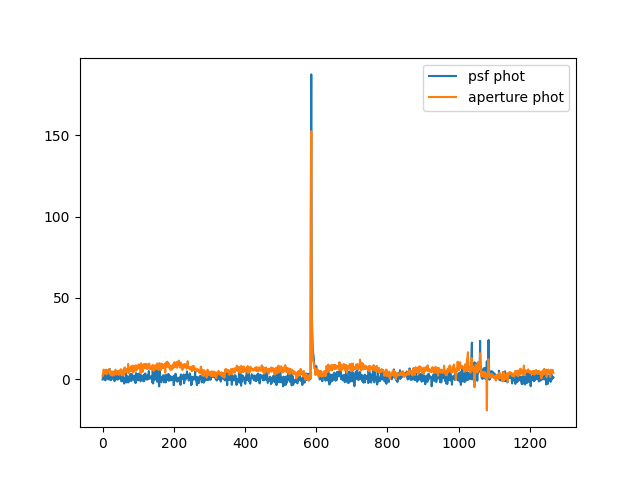

In [251]:
plt.figure()
plt.plot(flux,label='psf phot')
plt.plot(tess.lc[1],label='aperture phot')
plt.legend()

getting TPF from TESScut
made reference
made source mask
calculating background
background subtracted
calculating centroids
!!Re-running for difference image!!
shifting images
remade mask
background
Background correlation correction
Field calibration
Target is above -30 dec, calibrating to PS1 photometry.


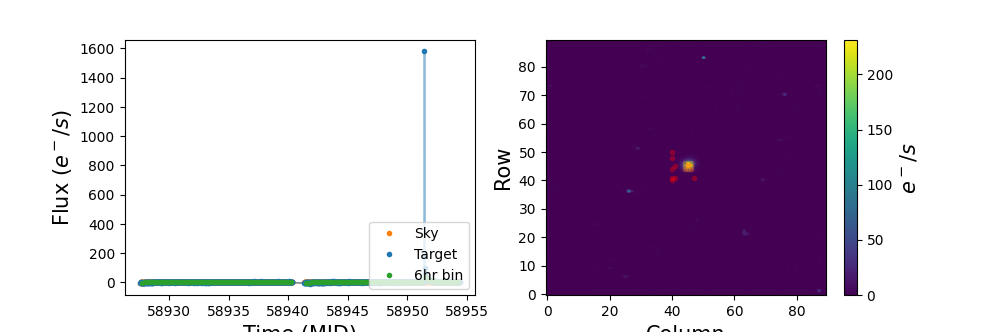

In [3]:
grb = tr.tessreduce(ra=278.313,dec=62.532,sector=23,plot=False,reduce=True)

100%|██████████| 1235/1235 [00:00<00:00, 1922.46it/s]


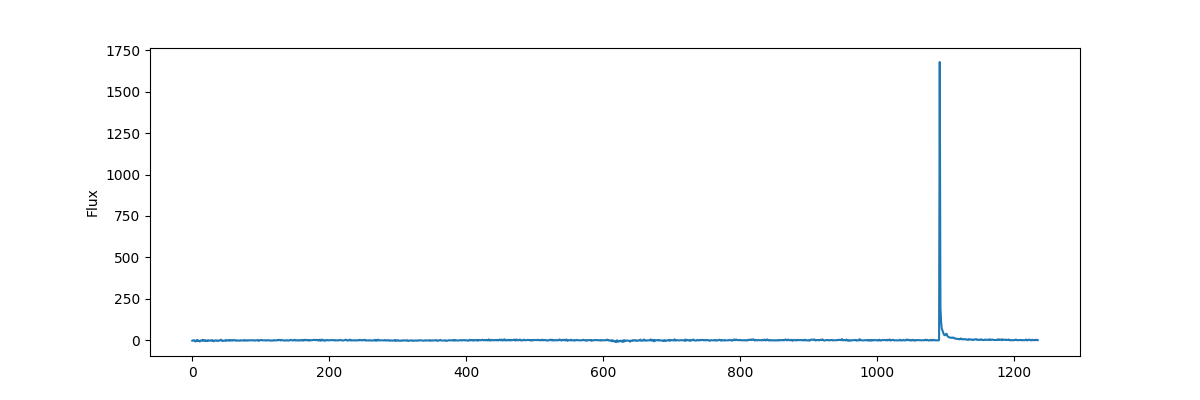

In [8]:
f = psf_photometry(grb,45,45,snap='brightest',size=5)

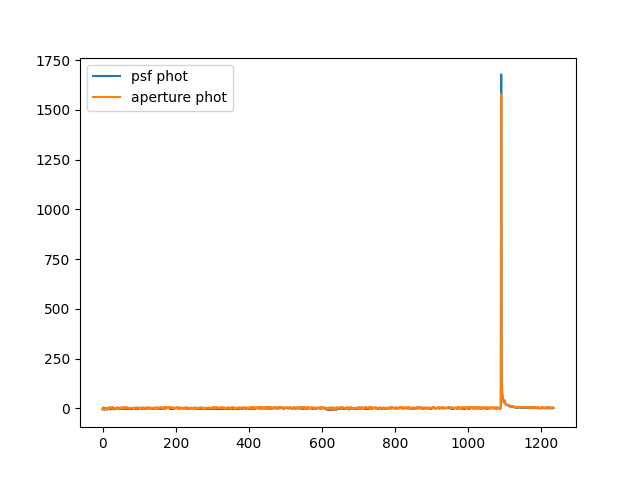

In [9]:
plt.figure()
plt.plot(f,label='psf phot')
plt.plot(grb.lc[1],label='aperture phot')
plt.legend()